In [1]:
from getpass import getpass

from epana import db
import pandas as pd

In [3]:
'''
select /*+ parallel 4 */
    loinc_cd,
    count(1) n_all, median(to_number(result_value)) median_all,
    count(case when to_number(result_value) > 0 then to_number(result_value) else NULL end) n_gt0,
    median(case when to_number(result_value) > 0 then to_number(result_value) else NULL end) median_gt0
from cdw.lab_result
where loinc_cd in ('1975-2', '2160-0', '732-8', '26484-6')
group by loinc_cd
;
'''

def get_labs_with_outliers():
    db_user = 'ephelps'
    db_pass = getpass('Password: ')
    sql = '''
        select /*+ parallel 4 */
            visit_id,
            institution,
            datasource_id,
            loinc_cd, lab_cd_orig,
            lab_cd_sys_orig,
            result_value,
            result_uom,
            norm_range_low,
            norm_range_high,
            panel_name,
            result_dt,
            src_desc ref_src_desc,
            tgt_code ref_tgt_code,
            tgt_desc ref_tgt_desc
        from cdw.lab_result lr
        inner join
            ( select distinct
                institution,
                decode(institution,
                        'MUSC_OACIS_LAB', 27,
                        'MUSC_EPIC_LAB',  26,
                        'SRHS', 21,
                        'GHS', 22,
                        'PH', 23,
                       0) dsid, 
                src_code, src_desc, tgt_code, tgt_desc
              from cdwref.ref_lab
              where tgt_code in ('1975-2', '2160-0',
                                 '732-8', '26484-6')
            ) ref_lr
        on (    lr.lab_cd_orig = ref_lr.src_code
            and lr.datasource_id = ref_lr.dsid )
    '''
    
    db_cdw = db.DbOra(db_user, db_pass, 'hssc-cdwr3-dtdb-p', 'dtprd2')
    cnames = ['visit_id', 'inst', 'dsid', 'loinc_cd', 'lab_cd_orig', 'lab_cd_sys_orig',
              'result_value', 'result_uom', 'norm_low', 'norm_high',
              'panel_name', 'result_dt', 'ref_src_desc',
              'ref_tgt_code', 'ref_tgt_desc'
             ]
    return pd.DataFrame(db_cdw.query(sql), columns=cnames)

%time df = get_labs_with_outliers()  # ~90 minutes

df.to_csv('pcori_labs_with_outliers.csv.gz', sep='|',
          index=False, compression='gzip')

Password: ········
CPU times: user 1min 45s, sys: 13.3 s, total: 1min 58s
Wall time: 2h 36min 55s


In [2]:
def get_labs_with_outliers_pmn():
    db_user = 'ephelps'
    db_pass = getpass('Password: ')
    sql = '''
        select
            encounterid,
            lab_loinc,
            result_date,
            result_num,
            result_unit
        from pcoristg.pmn_lab_result_cm
        where lab_loinc in ('1975-2', '2160-0', '732-8', '26484-6')
    '''
    
    db_cdm = db.DbOra(db_user, db_pass, 'hssc-cdwr3-i2b2db-p', 'i2bhsc')
    cnames = ['encounterid', 'lab_loinc', 'result_date', 'result_num', 'result_unit']
    return pd.DataFrame(db_cdm.query(sql), columns=cnames)

%time df = get_labs_with_outliers_pmn()

df.to_csv('pcori_labs_with_outliers_pmn.csv.gz', sep='|',
          index=False, compression='gzip')

Password: ········
CPU times: user 11.4 s, sys: 1.99 s, total: 13.4 s
Wall time: 20min 32s


In [2]:
%time df_cdw = pd.read_csv('pcori_labs_with_outliers.csv.gz', sep='|')
%time df_cdm = pd.read_csv('pcori_labs_with_outliers_pmn.csv.gz', sep='|')

CPU times: user 19.1 s, sys: 1.07 s, total: 20.2 s
Wall time: 20.2 s
CPU times: user 2.93 s, sys: 52.1 ms, total: 2.98 s
Wall time: 2.98 s


In [ ]:
def get_visit_deid():
    db_user = 'ephelps'
    db_pass = getpass('Password: ')
    sql = '''
        select /*+ parallel 4 */
            *
        from cdw.visit_deid_map_cc_jul18_rel
    '''
    
    db_cdw = db.DbOra(db_user, db_pass, 'hssc-cdwr3-dtdb-p', 'dtprd2')
    cnames = ['visit_id', 'visit_deid', 'patient_deid']
    return pd.DataFrame(db_cdw.query(sql), columns=cnames)

%time df = get_visit_deid()
df.to_csv('visit_deid_map_cc_jul18_rel.csv.gz', sep='|',
          index=False, compression='gzip')

Password: ········


In [4]:
print(len(df_cdw))
print(len(df_cdm))

11037528
3585603
0


In [4]:
df.head(3).T

0                    1                    2
inst                  MUSC_OACIS_LAB       MUSC_OACIS_LAB       MUSC_OACIS_LAB
dsid                              27                   27                   27
loinc_cd                      2160-0               2160-0               1975-2
lab_cd_orig                     2762                 2762                12461
lab_cd_sys_orig           CREATININE           CREATININE     BILIRUBIN, TOTAL
result_value                    18.6                  1.1                  0.4
result_uom                     MG/DL                MG/DL                MG/DL
norm_low                         0.6                  0.6                  0.2
norm_high                        1.3                  1.3                  1.3
panel_name                CREATININE           CREATININE     BILIRUBIN, TOTAL
result_dt        2013-02-16 17:50:00  2013-02-16 17:55:00  2013-02-16 17:55:00
ref_src_desc              CREATININE           CREATININE     BILIRUBIN, TOTAL
ref_tgt_code                  2160-0               2160-0               1975-2
ref_tgt_desc              Creatinine           Creatinine      Total bilirubin

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt

In [6]:
from epana import tabular

In [7]:
%time df_summ = tabular.get_summary(df)

CPU times: user 4min 22s, sys: 17.5 s, total: 4min 39s
Wall time: 4min 39s


In [8]:
df_summ

n_not_null  n_null   n_zero n_distinct  \
inst              11019230       0        0          5   
dsid              11019230       0        0          5   
loinc_cd          10696289  322941        0          4   
lab_cd_orig       11019230       0        0         19   
lab_cd_sys_orig   11019230       0        0         17   
result_value      11012766    6464     2447       2673   
result_uom        11012465    6765        0          6   
norm_low          10954860   64370  1533702         35   
norm_high         10954860   64370        0         50   
panel_name        11019230       0        0         42   
result_dt         11019230       0        0    1928335   
ref_src_desc      11019230       0        0         15   
ref_tgt_code      11019230       0        0          4   
ref_tgt_desc      11019230       0        0          5   

                                            vlen                  min  \
inst               (5.902545822167248, 5, 2, 14)                  GHS   
dsid                              (2.0, 1, 2, 2)                   21   
loinc_cd            (5.940072128451806, 4, 3, 7)                  NaN   
lab_cd_orig        (5.6009104991909595, 5, 3, 7)                12461   
lab_cd_sys_orig  (15.140899590987756, 11, 9, 31)      BILIRUBIN TOTAL   
result_value       (3.3224499352495593, 3, 3, 5)                    0   
result_uom          (4.965320353600025, 4, 1, 6)                  NaN   
norm_low           (3.2393968544081573, 2, 3, 4)                    0   
norm_high          (3.2402716886751617, 2, 3, 4)                  0.4   
panel_name        (23.14641994041326, 25, 3, 37)         .Manual Diff   
result_dt                      (19.0, 1, 19, 19)  1916-02-22 11:48:00   
ref_src_desc      (17.29350553532325, 10, 9, 31)      BILIRUBIN TOTAL   
ref_tgt_code        (6.043141036170404, 3, 5, 7)               1975-2   
ref_tgt_desc       (9.926183589960461, 4, 9, 24)            Bilirubin   

                                 max                      most_common  \
inst                            SRHS                               PH   
dsid                              27                               23   
loinc_cd                         NaN                           2160-0   
lab_cd_orig                     TBIL                           2160-0   
lab_cd_sys_orig      Total Bilirubin                       Creatinine   
result_value                     250                              0.7   
result_uom                       NaN                            mg/dL   
norm_low                          59                              0.6   
norm_high                         64                              1.3   
panel_name                       Rpr  Comprehensive Metabolic Profile   
result_dt        2018-07-14 19:30:00              2016-07-26 10:10:00   
ref_src_desc         Total bilirubin                       Creatinine   
ref_tgt_code                   732-8                           2160-0   
ref_tgt_desc         Total bilirubin                       Creatinine   

                n_most_common    dtype  
inst                  3742976   object  
dsid                  3742976    int64  
loinc_cd              6756781   object  
lab_cd_orig           3026418   object  
lab_cd_sys_orig       3282324   object  
result_value           759646  float64  
result_uom            6350340   object  
norm_low              2623563  float64  
norm_high             3369884  float64  
panel_name            2024868   object  
result_dt                 283   object  
ref_src_desc          3119463   object  
ref_tgt_code          6756784   object  
ref_tgt_desc          6756784   object

In [9]:
df.loc[:,'lab_cd_sys_orig'] = df.lab_cd_sys_orig.str.upper()
df.loc[:,'result_uom'] = df.result_uom.str.upper()

In [10]:
freq_cols = ['inst', 'dsid', 'lab_cd_orig', 'lab_cd_sys_orig', 'result_uom',
             'ref_src_desc', 'loinc_cd', 'ref_tgt_code', 'ref_tgt_desc']
df_freq = tabular.freq(df, freq_cols, 2)

In [11]:
df_freq_sorted = df_freq.sort_values(['inst', 'dsid', 'lab_cd_orig', 'result_uom'])

In [12]:
df_freq_sorted

inst  dsid lab_cd_orig                  lab_cd_sys_orig  \
0              GHS    22       CREAT             DESCRIPTION REQUIRED   
1              GHS    22        TBIL                  BILIRUBIN TOTAL   
2    MUSC_EPIC_LAB    26     1510379                CREATININE, SERUM   
3    MUSC_EPIC_LAB    26     1511105                       CREATININE   
4    MUSC_EPIC_LAB    26     1511105                   POC CREATININE   
5    MUSC_EPIC_LAB    26     1526296                       CREATININE   
6    MUSC_EPIC_LAB    26     1534076                  BILIRUBIN TOTAL   
7    MUSC_EPIC_LAB    26     1534446         MONOCYTES ABSOLUTE COUNT   
8    MUSC_EPIC_LAB    26     1552106                   BILIRUBIN, POC   
9    MUSC_EPIC_LAB    26     1810002                 BILIRUBIN, TOTAL   
10   MUSC_EPIC_LAB    26     1810219                        MONOCYTES   
11   MUSC_EPIC_LAB    26     1810219                        MONOCYTES   
12   MUSC_EPIC_LAB    26        3686                       CREATININE   
13  MUSC_OACIS_LAB    27       12461                 BILIRUBIN, TOTAL   
14  MUSC_OACIS_LAB    27        2762                       CREATININE   
15  MUSC_OACIS_LAB    27       28192                       CREATININE   
16              PH    23      1975-2                 BILIRUBIN, TOTAL   
17              PH    23      1975-2                 BILIRUBIN, TOTAL   
18              PH    23      2160-0                       CREATININE   
19              PH    23      2160-0                       CREATININE   
21              PH    23      2160-0                       CREATININE   
20              PH    23      2160-0                       CREATININE   
22              PH    23       732-8                       LYMPHOCYTE   
23              PH    23       732-8                       LYMPHOCYTE   
24              PH    23        NBIL        BILIRUBIN TOTAL, NEONATAL   
25            SRHS    21      1975-2   BILIRUBIN:MCNC:PT:SER/PLAS:QN:   
26            SRHS    21      2160-0  CREATININE:MCNC:PT:SER/PLAS:QN:   
27            SRHS    21         CRE                       CREATININE   
28            SRHS    21         CRE                       CREATININE   
29            SRHS    21        TBIL                  TOTAL BILIRUBIN   

   result_uom                     ref_src_desc loinc_cd ref_tgt_code  \
0       MG/DL                       Creatinine   2160-0       2160-0   
1       MG/DL                  Total bilirubin   1975-2       1975-2   
2       MG/DL                CREATININE, SERUM   2160-0       2160-0   
3       MG/DL                   POC CREATININE   2160-0       2160-0   
4       MG/DL                   POC CREATININE   2160-0       2160-0   
5       MG/DL                       CREATININE   2160-0       2160-0   
6       MG/DL                  BILIRUBIN TOTAL   1975-2       1975-2   
7      K/CUMM         MONOCYTES ABSOLUTE COUNT  26484-6      26484-6   
8           1                   BILIRUBIN, POC   1975-2       1975-2   
9       MG/DL                 BILIRUBIN, TOTAL   1975-2       1975-2   
10          %                        MONOCYTES  26484-6      26484-6   
11          1                        MONOCYTES  26484-6      26484-6   
12          1                       CREATININE   2160-0       2160-0   
13      MG/DL                 BILIRUBIN, TOTAL   1975-2       1975-2   
14      MG/DL                       CREATININE   2160-0       2160-0   
15      MG/DL                       CREATININE   2160-0       2160-0   
16      MG/DL                 Bilirubin, Total   1975-2       1975-2   
17      MG/DL   Bilirubin:MCnc:Pt:Ser/Plas:Qn:   1975-2       1975-2   
18          1                       Creatinine   2160-0       2160-0   
19          1  Creatinine:MCnc:Pt:Ser/Plas:Qn:   2160-0       2160-0   
21      MG/DL  Creatinine:MCnc:Pt:Ser/Plas:Qn:   2160-0       2160-0   
20      MG/DL                       Creatinine   2160-0       2160-0   
22          %                       Lymphocyte    732-8        732-8   
23          1         

In [13]:
def percentile(n):
    def percentile_(x):
        return pd.np.percentile(x, n)
    percentile_.__name__ = 'q_%s' % n
    return percentile_

def mean_no_outliers(qi, qf):
    def mean_no_outliers_(X):
        lo = pd.np.percentile(X, qi)
        hi = pd.np.percentile(X, qf)
        return pd.np.mean([x for x in X if x >= lo and x <= hi])
    mean_no_outliers_.__name__ = 'mean_%s_%s' % (qi, qf)
    return mean_no_outliers_

In [14]:
# df.groupby(freq_cols)[['result_value']].mean().reset_index()
df_agg = df.groupby(freq_cols)[['result_value']].agg(['count', 'mean', 'median', 'min', 'max', 'std',
                                                      percentile(10), percentile(90),
                                                      mean_no_outliers(10, 90)]
                                                    ).sort_values('ref_tgt_code')
df_agg.columns = df_agg.columns.droplevel()
df_agg = df_agg.reset_index()
df_agg.columns.values[0] = 'lab_inst'
df_agg.columns.values[3] = 'lab_desc_orig'
df_agg.columns.values[4] = 'lab_result_uom'
df_agg.columns.values[6] = 'lab_loinc_cd'
cols = ['lab_inst', 'lab_cd_orig', 'lab_desc_orig', 'lab_loinc_cd', 'lab_result_uom',
        'count', 'mean', 'median', 'min', 'max', 'std', 'q_10', 'q_90', 'mean_10_90',
        'ref_src_desc', 'ref_tgt_code', 'ref_tgt_desc']
df_agg = df_agg[cols]

/home/ephelps/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ephelps/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
df_agg = df_agg.drop([9, 13, 15])

In [16]:
df_agg = df_agg.merge(
    df_agg.groupby(['lab_inst', 'lab_loinc_cd'])[['count']].sum().reset_index(),
    on=['lab_inst', 'lab_loinc_cd'], suffixes=('', '_')
)
df_agg['perc_of_inst_loinc'] = 100*df_agg['count']/df_agg['count_']
df_agg.drop('count_', axis=1, inplace=True)

df_agg = df_agg.merge(
    df_agg.groupby(['lab_loinc_cd'])[['count']].sum().reset_index(),
    on=['lab_loinc_cd'], suffixes=('', '_')
)
df_agg['perc_of_loinc'] = 100*df_agg['count']/df_agg['count_']

df_agg.drop('count_', axis=1, inplace=True)
df_agg = df_agg[[
    'lab_inst', 'lab_cd_orig', 'lab_desc_orig', 'lab_loinc_cd',
    'lab_result_uom', 'count', 'perc_of_loinc', 'perc_of_inst_loinc',
    'mean', 'median', 'min', 'max', 'std', 'q_10', 'q_90', 'mean_10_90',
    'ref_src_desc', 'ref_tgt_code', 'ref_tgt_desc',
]]

In [65]:
df_agg.to_csv('bad_loincs_aggsumm.csv', sep='\t')

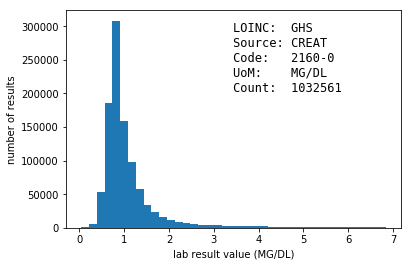

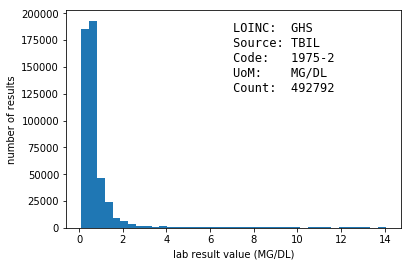

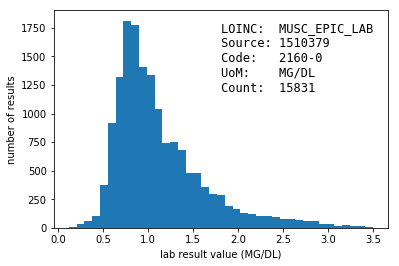

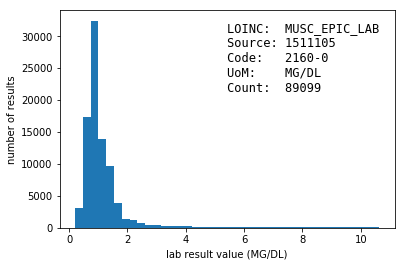

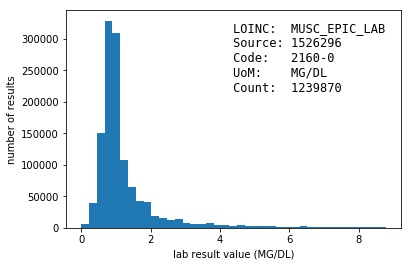

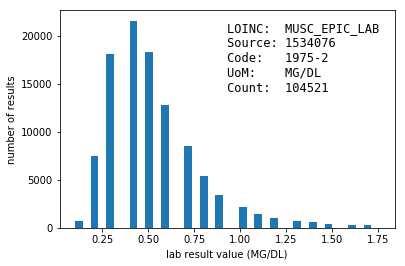

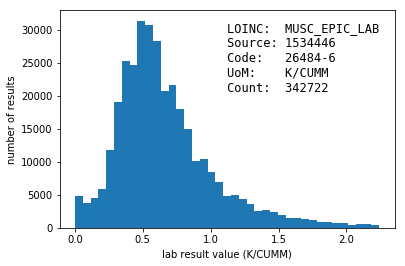

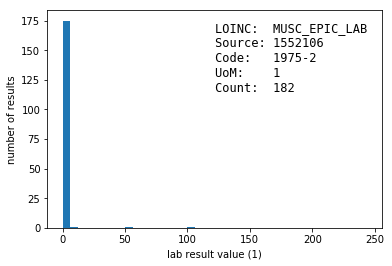

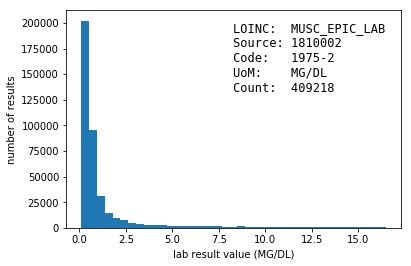

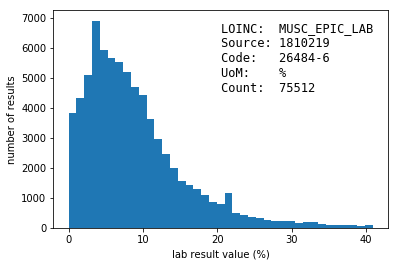

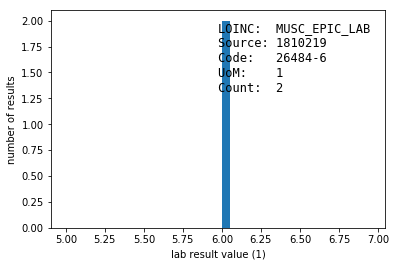

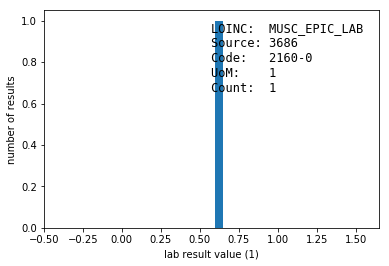

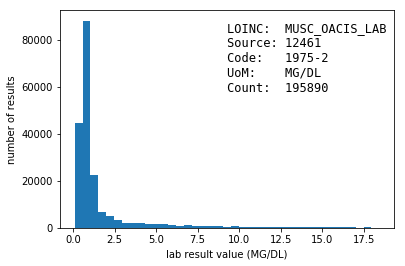

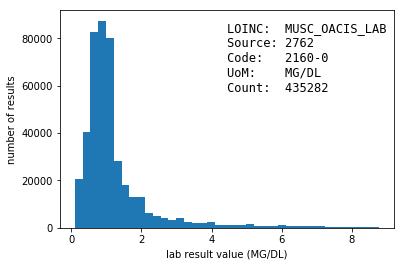

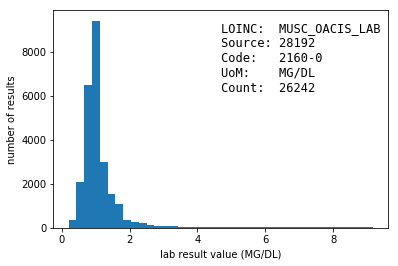

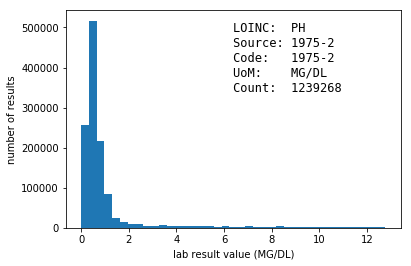

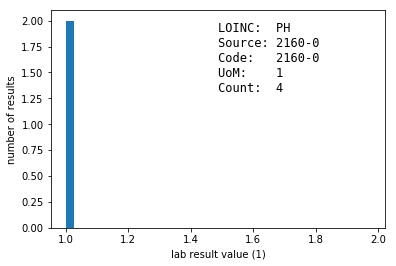

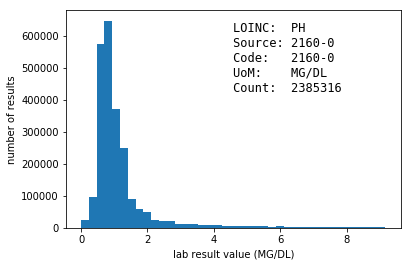

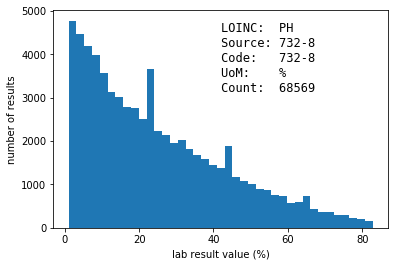

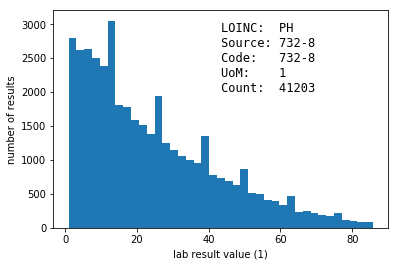

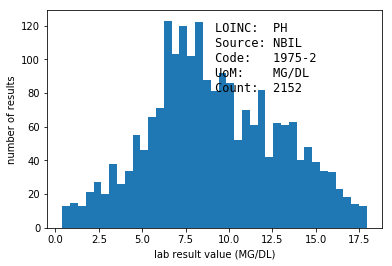

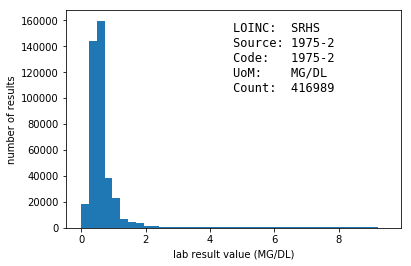

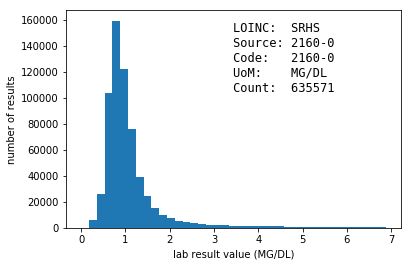

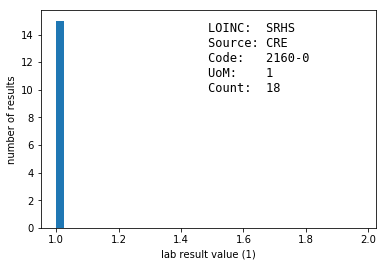

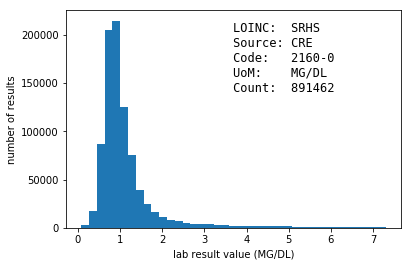

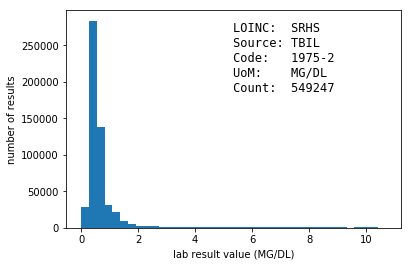

In [78]:
result_vals_dict = {}
outlier_ranges = { '2160-0'
for k,grp in df.groupby(['inst', 'lab_cd_orig', 'loinc_cd', 'result_uom']):
    result_vals_dict[k] = grp.result_value.values
    kstr = '%s | %s | %s | %s' % k
    panel_text = 'LOINC:  %s\nSource: %s\nCode:   %s\nUoM:    %s\nCount:  %d' % (k[0], k[1], k[2], k[3],
                                                                                len(result_vals_dict[k]))
    X = result_vals_dict[k]
    lo, hi = min(X), pd.np.percentile(X, 99)
    if lo == hi:
        lo = lo-1
        hi = hi+1
#     if k[1] == '1552106':
#         lo = 0
#         hi = 16
#     step_size = round((hi-lo)/100.0,1)
    step_size = (hi-lo)/40.0
#     step_size = 0.1
    plt.hist(X, bins=pd.np.arange(lo, hi, step_size))
    plt.text(0.50, 0.95, panel_text, fontsize=12, family='monospace',
             transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left')
    plt.xlabel('lab result value (%s)' % k[3])
    plt.ylabel('number of results')
    filename = '%s_%s_%s_%s.png' % k
    filename = filename.replace('/', '_per_')
    plt.savefig(filename)
    plt.show()

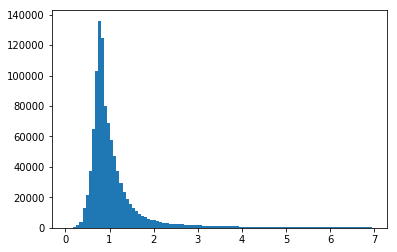

In [19]:
X = result_vals_dict[('GHS', 'CREAT', '2160-0', 'MG/DL')]
lo, hi = min(X), pd.np.percentile(X, 99)
plt.hist(X, bins=pd.np.arange(lo, hi, (hi-lo)/100.0))
plt.show()

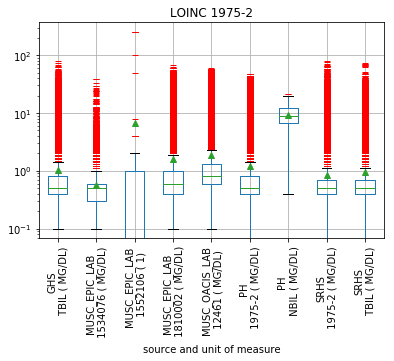

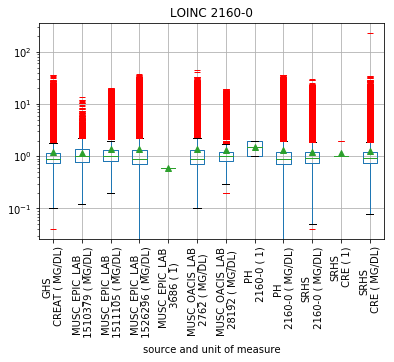

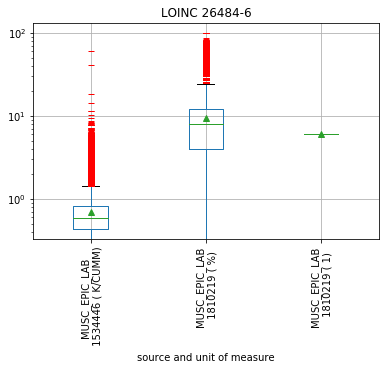

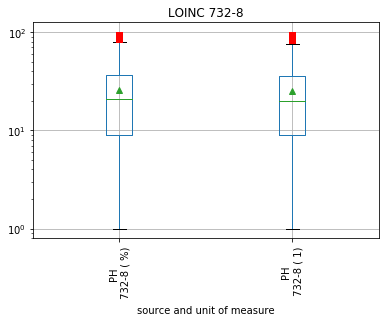

In [75]:
# ['inst', 'lab_cd_orig', 'loinc_cd', 'result_uom']
flierprops = dict(marker='_', markeredgecolor='red')
for k,g in df.groupby(['loinc_cd']):
    g.boxplot('result_value', by=['inst', 'lab_cd_orig', 'result_uom'],
              showmeans=True, flierprops=flierprops) #, whis=[10,90])
    plt.xticks(rotation=90)
    locs, lbls = plt.xticks()
    for lbl in lbls:
        lbl_str = lbl.get_text()
        lbl_str = lbl_str.strip('(').strip(')')
        (inst, cd, uom) = lbl_str.split(',')
        lbl.set_text('%s\n%s (%s)' % (inst, cd, uom))
    plt.xticks(locs, lbls)
    plt.title('LOINC %s' % k)
    plt.suptitle('')
    plt.yscale('log')
    plt.xlabel('source and unit of measure')
    plt.savefig('%s_boxplots.png')
    plt.show()

In [80]:
df_agg.columns

Index(['lab_inst', 'lab_cd_orig', 'lab_desc_orig', 'lab_loinc_cd',
       'lab_result_uom', 'count', 'perc_of_loinc', 'perc_of_inst_loinc',
       'mean', 'median', 'min', 'max', 'std', 'q_10', 'q_90', 'mean_10_90',
       'ref_src_desc', 'ref_tgt_code', 'ref_tgt_desc'],
      dtype='object')

In [81]:
df_agg[df_agg.lab_loinc_cd=='1975-2']['count'].sum()

2790625